# Data Collation, Exploration & Preparation

This section describes the sequence and findings of the process of collating the source data, validating and then preparing it for subsequent analysis.

In [1]:
# General setup and imports used throughout the Jupyter Notebook
#
# Libraries For file handling and dataframes
import os
import json
from IPython.display import display
import pandas as pd 

# Libraires fo plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Other Libraries
import math
import nltk
nltk.download('vader_lexicon')

# Variables used throughout the notebook
DATA_DIRECTORY = 'JCPenney_Data_Original'  # Designated data folder within the current working directory
AUGMENTED_DATA = 'Data_Additional'         # Additional data sources
 
# Simple utility functions to obtain and summarise key elements of a provided dataframe
#
def print_file_summary(data_frame):
    # Create a temporary df and ensure no lists remain, so that unique items can be identified for uniquness
    temp_df = data_frame.copy()
    temp_df = temp_df.map(lambda cell: str(cell) if isinstance(cell, list) else cell)
    
    # Calculate some 
    summary_of_df = pd.DataFrame({'Count': data_frame.count(),
                                 'Missing': data_frame.isnull().sum(), 'Empty': 0,
                                 'Unique': temp_df.nunique(),
                                 'Type': data_frame.dtypes, 
                                 'String': 0, 'Int': 0, 'Float': 0, 'List': 0
                                 })
    summary_of_df['Empty'] = (data_frame == '').sum()
    summary_of_df['String'] = data_frame.map(lambda cell: isinstance(cell, str)).sum()
    summary_of_df['Int'] = data_frame.map(lambda cell: isinstance(cell, int)).sum()
    summary_of_df['Float'] = data_frame.map(lambda cell: isinstance(cell, float)).sum()
    summary_of_df['List'] = data_frame.map(lambda cell: isinstance(cell, list)).sum()

    display(summary_of_df)

def print_full_summary(title, data_frame):
    # Print the summary and head for the given dataframe
    # Used frequently in the notebook so created a function to reduce repetition
    print(title)
    print_file_summary(data_frame)
    print(f'First 3 Rows')
    display(data_frame.head(3))


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/stuartgow/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Provided Data Sources & Content

The provided data sources for this analysis of JC Penney consists of two JSON files and three CSV files:
- JSON: jcpenney_products, jcpenney_reviewers
- CSV: products, reviews, users

It was not immediately obvious what the relationships between the two types of data files were but the json and CSV files appear to be partial duplicates of each other; also the three CSV files hold slightly less information (eg sales price is missing from the csv files). The CSV files appear to be a first attempt to extract data from the json files (eg the json products file has a JSON field holding multiple user reviews and this has looks to have been extracted to prepare the reviews.csv file).

Given the above, the approach used in this analysis was to go back to the 'original' JSON files and work from these but with a sanity check against the three CSV files to make sure no data was missed or inconsistent.

### Load JSON Data Files

It is assumed that the data is a snapshot extract of sales information from JCP operational system and the bulk of this has been flattened and used to create the jcpenney_products.json file and the jcpenney_reviewers.json file.

The two tables below show the data items and key counts for each file.

In [2]:
# Load the JSON product file and examine the format and content
# NB: Use pandas json load to directly create a dataframe

# Products file source
file_name = 'jcpenney_products.json'
file_path = os.path.join(os.getcwd(), DATA_DIRECTORY, file_name)
if not os.path.isfile(file_path):
    raise Exception(f'File not found: {file_path}')

# File load into a Pandas dataframe, retained and not amended
source_jcp_products_df = pd.read_json(file_path, lines=True)
                    
# Initial look at the file and data fields
print(f'File Summary for: {file_name}')
print_file_summary(source_jcp_products_df)
print(f'First 3 Rows')
display(source_jcp_products_df.head(3))


# Tidy up
del file_name, file_path

File Summary for: jcpenney_products.json


,Count,Missing,Empty,Unique,Type,String,Int,Float,List
uniq_id,7982,0,0,7982,object,7982,0,0,0
sku,7982,0,67,6044,object,7982,0,0,0
name_title,7982,0,0,6002,object,7982,0,0,0
description,7982,0,543,5620,object,7982,0,0,0
list_price,7982,0,2166,1037,object,7982,0,0,0
sale_price,7982,0,18,2063,object,7982,0,0,0
category,7982,0,636,1169,object,7982,0,0,0
category_tree,7982,0,636,1997,object,7982,0,0,0
average_product_rating,7982,0,0,153,float64,0,0,7982,0
product_url,7982,0,0,7982,object,7982,0,0,0


First 3 Rows


,uniq_id,sku,name_title,description,list_price,sale_price,category,category_tree,average_product_rating,product_url,product_image_urls,brand,total_number_reviews,Reviews,Bought With
0,b6c0b6bea69c722939585baeac73c13d,pp5006380337,Alfred Dunner® Essential Pull On Capri Pant,You'll return to our Alfred Dunner pull-on cap...,41.09,24.16,alfred dunner,jcpenney|women|alfred dunner,2.625,http://www.jcpenney.com/alfred-dunner-essentia...,http://s7d9.scene7.com/is/image/JCPenney/DP122...,Alfred Dunner,8,"[{'User': 'fsdv4141', 'Review': 'You never hav...","[898e42fe937a33e8ce5e900ca7a4d924, 8c02c262567..."
1,93e5272c51d8cce02597e3ce67b7ad0a,pp5006380337,Alfred Dunner® Essential Pull On Capri Pant,You'll return to our Alfred Dunner pull-on cap...,41.09,24.16,alfred dunner,jcpenney|women|alfred dunner,3.000,http://www.jcpenney.com/alfred-dunner-essentia...,http://s7d9.scene7.com/is/image/JCPenney/DP122...,Alfred Dunner,8,"[{'User': 'tpcu2211', 'Review': 'You never hav...","[bc9ab3406dcaa84a123b9da862e6367d, 18eb69e8fc2..."
2,013e320f2f2ec0cf5b3ff5418d688528,pp5006380337,Alfred Dunner® Essential Pull On Capri Pant,You'll return to our Alfred Dunner pull-on cap...,41.09,24.16,view all,jcpenney|women|view all,2.625,http://www.jcpenney.com/alfred-dunner-essentia...,http://s7d9.scene7.com/is/image/JCPenney/DP122...,Alfred Dunner,8,"[{'User': 'pcfg3234', 'Review': 'You never hav...","[3ce70f519a9cfdd85cdbdecd358e5347, b0295c96d2b..."


In [3]:
# Load the JSON reviewers file and examine the format and content
# NB: Use pandas json load to directly create a dataframe

# Reviewers file source
file_name = 'jcpenney_reviewers.json'
file_path = os.path.join(os.getcwd(), DATA_DIRECTORY, file_name)
if not os.path.isfile(file_path):
    raise Exception(f'File not found: {file_path}')

# File load into a Pandas dataframe, retained and not amended
source_jcp_reviewers_df = pd.read_json(file_path, lines=True)
                    
# Initial look at the file and data fields
print(f'File Summary for: {file_name}')
print_file_summary(source_jcp_reviewers_df)
print(f'First 3 Rows')
display(source_jcp_reviewers_df.head(3))

# Tidy up
del file_name, file_path

File Summary for: jcpenney_reviewers.json


,Count,Missing,Empty,Unique,Type,String,Int,Float,List
Username,5000,0,0,4999,object,5000,0,0,0
DOB,5000,0,0,52,object,5000,0,0,0
State,5000,0,0,57,object,5000,0,0,0
Reviewed,5000,0,0,4030,object,0,0,0,5000


First 3 Rows


,Username,DOB,State,Reviewed
0,bkpn1412,31.07.1983,Oregon,[cea76118f6a9110a893de2b7654319c0]
1,gqjs4414,27.07.1998,Massachusetts,[fa04fe6c0dd5189f54fe600838da43d3]
2,eehe1434,08.08.1950,Idaho,[]


## Working Data Structure - Validation & Augmentation 

### Data Structure Summary

The five data sources provided were examined and validated in more detail in order to understand the contents and data structure, and to complete any cleaning required. In addition, areas requiring augmentation were identified and additional data was sourced and combined with the original sources. The resulting working data structure consists of five dataframes, their preparation and content is described in the sections that follow, in the order of their preparation. In summary the five dataframes are:

***Sales***

- Details of all sales activity, 7,982 sales records
- Uniquely identified by the key 'uniq_id', in the Pandas dataframe: *sales_df*
- Sourced from the provided file: jcpenney_products.json
- A relatively small number of sales prices were missing 

***Customer Sales Reviews***

- Details of all customer reviews, 39,063 in total
- Uniquely identified by combined 'uniq_id' + 'customer_id', in the Pandas dataframe: *customer_reviews_df*
- Sourced from the provided file: jcpenney_products.json 
- Major issues with the quality of the reviews and and so of limited use in analysis. For example, 15,535 reviews appear to be duplicated across different customers. This could be a data export issue or even the introduction of fake reviews

***Customer Details***

- A reference list of 5,001 unique JCP customers who have submitted reviews of purchases
- Uniquely identified by the key 'customer_id', in the Pandas dataframe: *customers_df*
- Sourced from the provided file: jcpenney_reviewers.json
- Major issues with the quality of date of birth information. Appears to be artificially generated and so of limited use in analysis

***Stock Details***

- A reference list of 1,154 unique stock items
- Uniquely identified by the key 'sku', in the Pandas dataframe: *stock_df*
- Sourced from the provided file: jcpenney_products.json
- Derived from the 6,044 unique items in the file jcpenney_products.json
- Some issues with basic data differences for stock but these have been rationalised

***States & Territories***

- A reference list of the 57 US states and territories, with population and JCP store numbers per state
- Uniquely identified by the key 'state_ISO', in the Pandas dataframe: *states_df*
- Sourced from the file: JCP_Stores_State_Collated.csv
- Originated from the JCP store locater website and from the US Census Bureau



### States & Territories

A reference list for all US states and territories. Contains 57 items (51 states and 6 territories). This the ISO code for later validation of the provided customers data and with population data and JCP store numbers to assist later geographic analysis.

The data was sourced from:
- JCP's store locator, see [website](https://www.jcpenney.com/locations/index.html)
- US Census Bureau, see [website](https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html)

***Data Content***

After review and validation the created dataframe, states_df, has 57 unique items. It consists of:

- territory_flag - Indicates whether a state or a territory
- state_ISO - ISO code of the state, territory
- state_name - Name of the state, territory
- population - Population at 2023
- stores_total - Total number of stores at November 2024

***Collation & Validation***

The additional data file, JCP_Stores_State_Collated.csv, was loaded and validated. 


In [4]:
# Establish a reference list of states/territories with additional data to augment

# Load the states .csv file, exit if do not exist or are invalid
file_path = os.path.join(os.getcwd(), AUGMENTED_DATA, 'JCP_Stores_State_Collated.csv')
if not os.path.isfile(file_path):
    raise Exception(f"File not found: {file_path}")
states_df = pd.read_csv(file_path)

# Initial look at the file and data fields
print(f'Summary of States - CSV')
print_file_summary(states_df)
print(f'First 3 rows')
display(states_df.head(3))

# Rename column names & set the index on ISO
states_df = states_df.rename(columns={'State or Territory': 'territory_flag', 
                                            'State_ISO': 'state_ISO', 'State_Name': 'state_name',
                                            'Population_2023': 'population',
                                            'Store_Count': 'stores_total'})
#states_df.set_index(keys='state_ISO', inplace=True)

# Convert population to int
states_df['population'] = states_df['population'].str.replace(',', '').astype(int)

# Final look at the file and data fields
print(f'Summary of States - CSV')
print_file_summary(states_df)
print(f'First 3 rows')
display(states_df.head(3))

# Tidy up
del file_path

# Provide a simple unique state lookup of ISO for a given name
def get_state(state_name):
    matched_state = states_df.loc[states_df['state_name'] == state_name]
    if len(matched_state) == 1:
        return matched_state.iloc[0]
    else:
        return None


Summary of States - CSV


,Count,Missing,Empty,Unique,Type,String,Int,Float,List
State or Territory,57,0,0,2,object,57,0,0,0
State_ISO,57,0,0,57,object,57,0,0,0
State_Name,57,0,0,57,object,57,0,0,0
Population_2023,57,0,0,57,object,57,0,0,0
Store_Count,57,0,0,26,int64,0,57,0,0


First 3 rows


,State or Territory,State_ISO,State_Name,Population_2023,Store_Count
0,State,AL,Alabama,"5,108,468",9
1,State,AK,Alaska,"733,406",1
2,State,AZ,Arizona,"7,431,344",17


Summary of States - CSV


,Count,Missing,Empty,Unique,Type,String,Int,Float,List
territory_flag,57,0,0,2,object,57,0,0,0
state_ISO,57,0,0,57,object,57,0,0,0
state_name,57,0,0,57,object,57,0,0,0
population,57,0,0,57,int64,0,57,0,0
stores_total,57,0,0,26,int64,0,57,0,0


First 3 rows


,territory_flag,state_ISO,state_name,population,stores_total
0,State,AL,Alabama,5108468,9
1,State,AK,Alaska,733406,1
2,State,AZ,Arizona,7431344,17


### Customers

Details of customers that have completed a review of a purchase made. With 5,001 unique customer records. All customers have a date of birth, however examination of this showed that only 14 were really unique and appear to be artificially generated. Arguably this field should be dropped as it will not provide any meaningful results. However, it has been retained purely so that it can be used to demonstrate analysis techniques.

***Data Content***

After review and validation the created dataframe, customers_df, has 5,001 unique customers. It consists of:

- customer_id - A unique alphanumeric id
- DOB - Date of birth
- state_ISO - ISO code for the state or territory. A cross-reference to the states_df

***Collation & Validation***

The provided data file, jcpenney_reviewers.json, was examined. As these appears to be detailing customers that have completed a review, the term 'customer' was used instead of reviewer. The following actions were taken:

- Fields Rename: Columns renamed to be consistent with other dataframes
- Duplicates: One customer_id was used twice. To preserve information, it was decided to keep the duplicates and assign them a new unique customer_id
- Date of Birth: Surprisingly for 5,001 customers only 52 birth dates were found. Closer examination revealed that a day, month sequence was incremented across years, with only 14 unique dates ranging nge only from 26 July to 8 August.
- States: When validating against the states reference file to obtain ISO codes, 187 customers did not match due to the incorrect naming of the US Virgin Islands and US Minor Outlying Islands, so these were corrected. Only the ISO code was retained and the full state name dropped, in preference to it being looked up when required
- uniq_id_list - This list was dropped once the details had been cross-checked against the new customer_reviews and sales dataframes.


Summary for customers


,Count,Missing,Empty,Unique,Type,String,Int,Float,List
customer_id,5000,0,0,4999,object,5000,0,0,0
DOB,5000,0,0,52,object,5000,0,0,0
state_name,5000,0,0,57,object,5000,0,0,0
uniq_id_list,5000,0,0,4030,object,0,0,0,5000


First 3 rows - Renamed Columns


,customer_id,DOB,state_name,uniq_id_list
0,bkpn1412,31.07.1983,Oregon,[cea76118f6a9110a893de2b7654319c0]
1,gqjs4414,27.07.1998,Massachusetts,[fa04fe6c0dd5189f54fe600838da43d3]
2,eehe1434,08.08.1950,Idaho,[]


Duplicated Customers:


,customer_id,DOB,state_name,uniq_id_list
731,dqft3311,28.07.1995,Tennessee,[5f280fb338485cfc30678998a42f0a55]
2619,dqft3311,03.08.1969,New Mexico,[571b86d307f94e9e8d7919b551c6bb52]


Double-Check No Remaining Duplicated Customers:


,customer_id,DOB,state_name,uniq_id_list


,Oldest,Youngest,Unique Dates
0,1950-08-08,2001-07-26,52


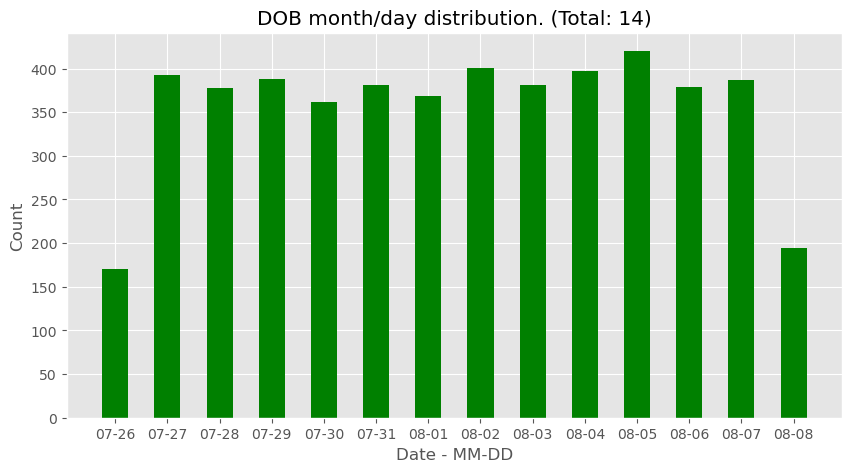

Unmatched States:


,customer_id,state_name
29,wjfh4432,Minor Outlying Islands
104,ulkz1412,Minor Outlying Islands
106,bsqg4331,Minor Outlying Islands
203,bbiv3413,Minor Outlying Islands
215,surt1311,U.S. Virgin Islands
...,...,...
4872,ypcn2342,U.S. Virgin Islands
4940,lric2324,U.S. Virgin Islands
4960,okun1224,Minor Outlying Islands
4970,kjgm1311,U.S. Virgin Islands


Unmatched States:


,customer_id,state_name


Customers by State:


In [5]:
# Establish a customer details dataframe 

# Create a new dataframe for all customer reviews
customers_df = source_jcp_reviewers_df.copy()

# Rename customer column names and validate content for each
customers_df = customers_df.rename(columns={'Username': 'customer_id', 
                                            'State': 'state_name',
                                            'Reviewed': 'uniq_id_list'})

# Print the file and data fields
print(f'Summary for customers')
print_file_summary(customers_df)
print(f'First 3 rows - Renamed Columns')
display(customers_df.head(3))

# Identify duplicate customers 
duplicates_flag = customers_df.duplicated(subset=['customer_id'], keep=False)
duplicated = customers_df[duplicates_flag]
print(f'Duplicated Customers:')
display(duplicated)

# Replace duplicates with new customer_id 'DUPnnnxxxxxxx' to preserve 
# Use itertuples as faster for larger datasets
dup_count = 0
for row in duplicated.itertuples():   
    dup_count += 1
    new_id = 'DUP' + str(dup_count).zfill(3) + row.customer_id     
    customers_df.at[row.Index, 'customer_id'] = new_id

# Double check no duplicates remain
duplicates_flag = customers_df.duplicated(subset=['customer_id'], keep=False)
duplicated = customers_df[duplicates_flag]
print(f'Double-Check No Remaining Duplicated Customers:')
display(duplicated)

# DOB convert to date format and examine the dates used
customers_df['DOB'] = pd.to_datetime(customers_df['DOB'], dayfirst=True, errors='coerce')
dates_grouped = customers_df.groupby('DOB').size().reset_index(name='counts')
date_range = pd.DataFrame({'Oldest': [dates_grouped['DOB'].min()],
                           'Youngest': [dates_grouped['DOB'].max()],
                           'Unique Dates': [len(dates_grouped)]})
display(date_range)

# Remove year to examine the day / month distribution & plot this
converted_dates = customers_df['DOB'].dt.strftime('%m-%d').reset_index().groupby('DOB').size()
fig, ax = plt.subplots(figsize =(10, 5))
ax.set_title(f'DOB month/day distribution. (Total: {len(converted_dates)})')
ax.set_xlabel('Date - MM-DD')
ax.set_ylabel('Count')
bars = ax.bar(converted_dates.index, converted_dates, color='green', width=0.5)
plt.show()

# States validation - lookup ISO codes, add to customer data and check for invalid matches
customers_df['state_ISO'] = customers_df['state_name'].apply(lambda x: get_state(x)['state_ISO'] if get_state(x) is not None else None)
unmatched_states = customers_df[customers_df['state_ISO'].isnull()]
print(f'Unmatched States:')
display(unmatched_states[['customer_id', 'state_name']])

# Names mismatch for US Virgin Islands and US Minor Outlying Islands
customers_df.replace('U.S. Virgin Islands', 'US Virgin Islands', inplace=True)
customers_df.replace('Minor Outlying Islands', 'US Minor Outlying Islands', inplace=True)

# Repeat the checks & drop state_name if all ISO populated
customers_df['state_ISO'] = customers_df['state_name'].apply(lambda x: get_state(x)['state_ISO'] if get_state(x) is not None else None)
unmatched_states = customers_df[customers_df['state_ISO'].isnull()]
print(f'Unmatched States:')
display(unmatched_states[['customer_id', 'state_name']])

# Drop the state name, rely on the ISO code and states lookup
if len(unmatched_states) != 0:
    raise Exception(f'Cannot match: {len(unmatched_states)} states')
customers_df = customers_df.drop('state_name', axis=1)

# Visual check on state details - PRint not included in report due to size
states = customers_df.groupby('state_ISO').size().reset_index(name='counts')
print(f'Customers by State:')
#display(states)

# Tidy up
del duplicates_flag, duplicated, dup_count, new_id, row
del dates_grouped, converted_dates, date_range
del unmatched_states, states


### Stock Details

Details of all stock (product) data. Contains 1,154 unique lines of stock with each uniquely identified by the key 'sku'. For each stock line the details include description and its list price. There was significant inconsistency of basic details (name, description, list price, image url) for stock items in the provided products file. An attempt has been made to rationalise the data by retaining the most commonly used data items.

***Data Content***

After review and validation the created dataframe, stock_df, has 1,154 unique stock records. It consists of:

- sku - The unique identifier for the stock item
- stock_name - Short name for the stock item
- description - A long description of the stock
- list_price - The standard price for the stock
- stock_image_url - URL for the website image for the stock
- brand - The manufacturer's name for the stock item, eg 'Alfred Dunner'

***Collation & Validation***

The provided data file, jcpenney_products.json, was examined and all stock specific data extracted into the stock_df dataframe. The following actions were taken:

- Missing SKU ids: 67 were missing, so generated ids were added according in line with the most common format structure, to pp600nnnnnnn
- Drop Fields: Drop all fields that are sales specific: 'uniq_id', 'sale_price', 'category', 'category_tree', 'average_product_rating', 'product_url', 'total_number_reviews', 'Reviews', 'Bought With'
- Stock Name: A significant number of names differed for the same sku. The first name has been retained
- Description: A significant number of descriptions differed for the same sku or were missing. The first name has been retained. However, still 50 had no description so 'No Description Available' was added
- List Price: A significant number of items had different prices for the same stock. So the most common price for each item was used. Even so, 182 stock items do not have a list price
- Stock Image URL: For 170 stock items, the urls did not all match and so the most frequent one was retained. As sample request of images was successful
- Brand: No missing or duplicated, so just copy one
- Rationalise Stock: Retain only a single unique sku record

***Reasons for Splitting Sales & Stock Data***

The provided file, jcpenney_products.json, appears to contain core stock information and sales specific information. For example a stock list price and a different sales price that varied depending on different sales categories. So stock data has been split out and cleaned in order to be able to more easily analyse stock vs sales data.

It has been assumed that the field sku is the 'Stock Keeping Unit' see [Wikipedia](https://en.wikipedia.org/wiki/Stock_keeping_unit) and should be a unique identifier. Therefore all instances of sku have been reviewed and collapsed down into a stock list dataframe, separate from sales activity. The 6,044 product rows have produced 1,154 stock lines.

In [8]:
# Establish a reference list of all product / stock details
# And also the initial draft of the sales dataframe for further preparation

# Create an initial new dataframe for all stock details
stock_df = source_jcp_products_df.copy()

# Print the file and data fields
print_full_summary('Summary For Stock/Sales/Product Data - Initial Look', stock_df)

# Flag all missing fields for easier checking and replacement
missing_flag = 'Missing'
stock_df.replace('', missing_flag, inplace=True)
stock_df.fillna(missing_flag, inplace=True)

# Count missing and check formats of SKU
sku_formats = {'pp500nnnnnn': r'^pp500\d{6}',
                '1xxxxxx': r'^1\w{6}',
                'enxnnnnnnnnnn': r'^en\D\d{10}',
                missing_flag: r'Missing'}
counts = {}
filtered = stock_df.copy()
for sku_format, regex_pattern in sku_formats.items():
    matched = stock_df[stock_df['sku'].str.contains(regex_pattern, na=False)]
    counts[sku_format] = len(matched)
    filtered = filtered[~filtered['sku'].isin(matched['sku'])]
print(f'Counts for SKU missing and format types + formats not matching')
display(counts)
display(filtered)

# Generate ids for missing SKU
# Use itertuples as faster for larger datasets
sku_count = 6000000000
missing_sku = stock_df[stock_df['sku'] == missing_flag]
for row in missing_sku.itertuples():
    sku_count += 1
    new_id = 'pp' + str(sku_count)
    stock_df.at[row.Index, 'sku'] = new_id
# Double-check all updated
missing_sku = stock_df[stock_df['sku'] == missing_flag]
display(missing_sku)

# Create an initial new dataframe for all sales details ready for later manipulation
sales_df = stock_df.copy()

# Drop non stock columns
columns_not_required = ['uniq_id', 'sale_price', 'category', 'category_tree', 'average_product_rating',
                        'product_url',
                        'total_number_reviews', 'Reviews', 'Bought With']
stock_df.drop(columns=columns_not_required, inplace=True, errors='ignore')

# Rename the retained columns 
# (nb all listed for documentation purposes)
stock_df = stock_df.rename(columns={'name_title': 'stock_name', 'description': 'description',
                                    'list_price': 'list_price',
                                    'product_image_urls': 'stock_image_url',
                                    'brand': 'brand'})


# Remove duplicated sku ids rows
# Checking consistency of the other columns
sku_duplicated = stock_df.groupby('sku').filter(lambda sku: len(sku) > 1)
print(f'duplicated skus: {len(sku_duplicated) }')
sku_groups_dup = sku_duplicated.groupby('sku')

# Iterate through all grouped sku ids and validate, select the individual column values
new_stock_df = stock_df.head(0).copy()
for sku, group in sku_groups_dup:
    new_sku = stock_df.head(0).copy()
    new_sku.at[0, 'sku'] = sku
    # stock name - Just retain the first record
    new_sku.at[0, 'stock_name'] = group['stock_name'].iloc[0]
    # description - Keep the first non-blank
    non_empty = group[group['description'] != missing_flag]
    if(len(non_empty) != 0):
        new_sku.at[0, 'description'] = non_empty['description'].iloc[0]
    else:
        new_sku.at[0, 'description'] = 'No Description Available'
    # list_price
    non_empty = group[group['list_price'] != missing_flag]
    if(len(non_empty) != 0):
        most_frequent = non_empty['list_price'].value_counts().idxmax()
        new_sku.at[0, 'list_price'] = most_frequent
    else:
        new_sku.at[0, 'list_price'] = 0
    # stock_image_url
    non_empty = group[group['stock_image_url'] != missing_flag]
    if(len(non_empty) != 0):
        most_frequent = non_empty['stock_image_url'].value_counts().idxmax()
        new_sku.at[0, 'stock_image_url'] = most_frequent
    else:
        new_sku.at[0, 'stock_image_url'] = 'No URL Available'
    # brand
    non_empty = group[group['brand'] != missing_flag]
    if(len(non_empty) != 0):
        new_sku.at[0, 'brand'] = non_empty['brand'].iloc[0]
    else:
        new_sku.at[0, 'brand'] = 'No Details Available'

    # Add the single row to the temporary duplicated stock dataframe
    new_stock_df = pd.concat([new_stock_df, new_sku], ignore_index=True)

# Finally, copy the reduced stock list and set all fields to appropriate types
stock_df = new_stock_df.copy()
stock_df['list_price'] = pd.to_numeric(stock_df['list_price'], errors='coerce')

# Print the file and data fields
print_full_summary('Summary For Stock Data - After Cleaning', stock_df)

# Tidy up
#del counts, filtered, matched, regex_pattern, sku_format, sku_formats, missing_flag, non_empty
#del sku_count, missing_sku, row, new_id, most_frequent
#del new_sku, new_stock_df, columns_not_required, sku, sku_duplicated, sku_groups_dup, group


Summary For Stock/Sales/Product Data - Initial Look


,Count,Missing,Empty,Unique,Type,String,Int,Float,List
uniq_id,7982,0,0,7982,object,7982,0,0,0
sku,7982,0,67,6044,object,7982,0,0,0
name_title,7982,0,0,6002,object,7982,0,0,0
description,7982,0,543,5620,object,7982,0,0,0
list_price,7982,0,2166,1037,object,7982,0,0,0
sale_price,7982,0,18,2063,object,7982,0,0,0
category,7982,0,636,1169,object,7982,0,0,0
category_tree,7982,0,636,1997,object,7982,0,0,0
average_product_rating,7982,0,0,153,float64,0,0,7982,0
product_url,7982,0,0,7982,object,7982,0,0,0


First 3 Rows


,uniq_id,sku,name_title,description,list_price,sale_price,category,category_tree,average_product_rating,product_url,product_image_urls,brand,total_number_reviews,Reviews,Bought With
0,b6c0b6bea69c722939585baeac73c13d,pp5006380337,Alfred Dunner® Essential Pull On Capri Pant,You'll return to our Alfred Dunner pull-on cap...,41.09,24.16,alfred dunner,jcpenney|women|alfred dunner,2.625,http://www.jcpenney.com/alfred-dunner-essentia...,http://s7d9.scene7.com/is/image/JCPenney/DP122...,Alfred Dunner,8,"[{'User': 'fsdv4141', 'Review': 'You never hav...","[898e42fe937a33e8ce5e900ca7a4d924, 8c02c262567..."
1,93e5272c51d8cce02597e3ce67b7ad0a,pp5006380337,Alfred Dunner® Essential Pull On Capri Pant,You'll return to our Alfred Dunner pull-on cap...,41.09,24.16,alfred dunner,jcpenney|women|alfred dunner,3.000,http://www.jcpenney.com/alfred-dunner-essentia...,http://s7d9.scene7.com/is/image/JCPenney/DP122...,Alfred Dunner,8,"[{'User': 'tpcu2211', 'Review': 'You never hav...","[bc9ab3406dcaa84a123b9da862e6367d, 18eb69e8fc2..."
2,013e320f2f2ec0cf5b3ff5418d688528,pp5006380337,Alfred Dunner® Essential Pull On Capri Pant,You'll return to our Alfred Dunner pull-on cap...,41.09,24.16,view all,jcpenney|women|view all,2.625,http://www.jcpenney.com/alfred-dunner-essentia...,http://s7d9.scene7.com/is/image/JCPenney/DP122...,Alfred Dunner,8,"[{'User': 'pcfg3234', 'Review': 'You never hav...","[3ce70f519a9cfdd85cdbdecd358e5347, b0295c96d2b..."


Counts for SKU missing and format types + formats not matching


{'pp500nnnnnn': 7505, '1xxxxxx': 394, 'enxnnnnnnnnnn': 13, 'Missing': 67}

,uniq_id,sku,name_title,description,list_price,sale_price,category,category_tree,average_product_rating,product_url,product_image_urls,brand,total_number_reviews,Reviews,Bought With
2269,9fa199671d88a2a3cddd06a0dac02763,0903a80,KitchenAid® Artisan® 5-qt. Stand Mixer KSM150PS,The mixer you've always dreamed of. Unique mix...,604.31,423.01,small appliances,jcpenney|for-the-home|small appliances,2.750,http://www.jcpenney.com/kitchenaid-artisan-5-q...,http://s7d9.scene7.com/is/image/JCPenney/09006...,Kitchen Aid,8,"[{'User': 'vlfw2311', 'Review': 'I dont know w...","[0f09d5de035bbb347c17f55222d9efa4, dae30fb78a6..."
3984,4875e80ad4e5d0d8970850046a4c8b8c,PP100000902,Alyx® Gauze Print Tank Top or Millennium Pants,Missing,Missing,24.1633,outfits you'll love,jcpenney|women|outfits you'll love,3.000,http://www.jcpenney.com/alyx-gauze-print-tank-...,http://s7d9.scene7.com/is/image/JCPenney/DP032...,Alyx,8,"[{'User': 'tlim1231', 'Review': 'I was worried...","[53cf4a9eb003e2b5e9c63722d1011951, 5b7416f4e6a..."
7884,6dcebbf40f3195554080edced28d401b,0903a80,KitchenAid® Artisan® 5-qt. Stand Mixer KSM150PS,The mixer you've always dreamed of. Unique mix...,Missing,604.31,wedding,jcpenney|wedding,3.125,http://www.jcpenney.com/kitchenaid-artisan-5-q...,http://s7d2.scene7.com/is/image/JCPenney/DP021...,Kitchen Aid,8,"[{'User': 'lzci4334', 'Review': 'I dont know w...","[eb8e7f2068b80379afbae5135b280c7b, 44725052ce6..."


,uniq_id,sku,name_title,description,list_price,sale_price,category,category_tree,average_product_rating,product_url,product_image_urls,brand,total_number_reviews,Reviews,Bought With


duplicated skus: 3026
Summary For Stock Data - After Cleaning


,Count,Missing,Empty,Unique,Type,String,Int,Float,List
sku,1154,0,0,1154,object,1154,0,0,0
stock_name,1154,0,0,1135,object,1154,0,0,0
description,1154,0,0,1081,object,1154,0,0,0
list_price,1154,0,0,322,float64,0,0,1154,0
stock_image_url,1154,0,0,1141,object,1154,0,0,0
brand,1154,0,0,228,object,1154,0,0,0


First 3 Rows


,sku,stock_name,description,list_price,stock_image_url,brand
0,0903a80,KitchenAid® Artisan® 5-qt. Stand Mixer KSM150PS,The mixer you've always dreamed of. Unique mix...,604.31,http://s7d9.scene7.com/is/image/JCPenney/09006...,Kitchen Aid
1,13cab12,JCPenney Home™ Saratoga Cut-to-Width Fringed B...,Saratoga cut--to-width blackout shade features...,27.80,http://s7d2.scene7.com/is/image/JCPenney/DP121...,JCP HOME
2,13e154b,Glamorise® Full-Figure Body Briefer - 6201,Glamorise's best-selling full-figure body brie...,81.97,http://s7d9.scene7.com/is/image/JCPenney/09006...,Glamorise


### Sales

Details of all sales activity. Contains 7,982 sales records with each uniquely identified by the key 'uniq_id'. The data for each sale includes the sales price, stock reference and sales channel information. Most of the data appeared complete and reasonably, although several hundred sales prices were in an invalid format or missing; the relatively small number should not skew later analysis.

***Data Content***

After review and validation the created dataframe, sales_df, has 7,982 records. It consists of:

- uniq_id - A unique identifier for the sales activity
- sku - A cross-reference for stock data in the stock_df
- sale_price - The price that the sales was 
- category_tree - A string breaking down the structure of the sales channel
- category - The bottom level of the category tree
- sales_product_url - JCP website url for the product details as sold
- average_product_rating - An average of the customer review scores (1 to 5) for this sale
- total_number_reviews - The total number of customer reviews for this sale
- bought_with_list - other sales at the same time as this sale

***Collation & Validation***

The provided data file, jcpenney_products.json, was examined and all sales specific data extracted into the sales_df dataframe. The following actions are highlighted:

- Invalid & Missing Prices: 263 sales prices were in a range format (34.5-45.9) and these were converted taking the average. And 18 had no price and so were zeroed
- Categories Missing: 636 categories, category trees are missing. About 10% of the 7,982 sales
- Sales Product URL: All good, no missing or duplicated. However, a sample of requests to use the URL failed
- Bought With: This was not reviewed and has been retained as source


In [7]:
# Establish a list of all product sales

# Use the initial sales file creating during the stock file creation, 
# and drop columns that were retained in the stock_df
columns_not_required = ['name_title', 'description', 'list_price', 'product_image_urls', 'brand']
sales_df.drop(columns=columns_not_required, inplace=True, errors='ignore')
 
 # Print the file and data fields
print_full_summary('Summary For Product Data - Initial Look', sales_df)

# Rename the retained columns (nb all listed for documentation purposes)
sales_df = sales_df.rename(columns={'uniq_id': 'uniq_id', 
                                    'sku': 'sku',
                                    'sale_price': 'sale_price',
                                    'category': 'category', 'category_tree': 'category_tree',
                                    'average_product_rating': 'average_product_rating',
                                    'product_url': 'sales_product_url',
                                    'total_number_reviews': 'total_number_reviews',
                                    'Reviews': 'reviews_list', 'Bought With': 'bought_with_list'})

# Flag all missing fields for easier checking and replacement
missing_flag = 'Missing'
sales_df.replace('', missing_flag, inplace=True)
sales_df.fillna(missing_flag, inplace=True)

# uniq_id - nb visual inspection shows no duplicate and no missing
# sku - validated during production of the sales file

# sale_price - several values missing and formatted as range numbers
# Clean up and convert to float
def convert_price(price):
    try:
        # Trap the values with a range
        if '-' in price:
            low, high = map(float, price.split('-'))
            averaged = (low + high) / 2
            return averaged
        if price == missing_flag:
            return 0.0
        return float(price)
    except:
        return 0.0
sales_df['sale_price'] = sales_df['sale_price'].apply(convert_price)

# category and category tree
missing_cat = len(sales_df[sales_df['category'] == missing_flag])
missing_cat_tree = len(sales_df[sales_df['category_tree'] == missing_flag])
print(f'Missing: Categories {missing_cat} Trees {missing_cat_tree}')

# product URL check
duplicates_count = sales_df.duplicated(subset=['sales_product_url'], keep=False).sum()
print(f'Duplicated URLs: {duplicates_count}')

# Create an initial new dataframe for customer reviews ready for later manipulation
working_customer_reviews_df = sales_df.copy()
columns_not_required = ['sku', 'sale_price', 'category', 'category_tree', 'sales_product_url', 'bought_with_list']
working_customer_reviews_df.drop(columns=columns_not_required, inplace=True, errors='ignore')

# From this sales df, drop reviews details, but keep averages 
# (nb the average and totals will be cross-checked as part of creating the reviews df)
columns_not_required = ['reviews_list']
sales_df.drop(columns=columns_not_required, inplace=True, errors='ignore')
    
# Print the file and data fields
print_full_summary('Summary For Sales Data - After Cleaning', sales_df)

# Tidy up
del columns_not_required
del missing_flag, missing_cat_tree, missing_cat, duplicates_count


Summary For Product Data - Initial Look


,Count,Missing,Empty,Unique,Type,String,Int,Float,List
uniq_id,7982,0,0,7982,object,7982,0,0,0
sku,7982,0,0,6110,object,7982,0,0,0
sale_price,7982,0,0,2063,object,7982,0,0,0
category,7982,0,0,1169,object,7982,0,0,0
category_tree,7982,0,0,1997,object,7982,0,0,0
average_product_rating,7982,0,0,153,float64,0,0,7982,0
product_url,7982,0,0,7982,object,7982,0,0,0
total_number_reviews,7982,0,0,22,int64,0,7982,0,0
Reviews,7982,0,0,7982,object,0,0,0,7982
Bought With,7982,0,0,7982,object,0,0,0,7982


First 3 Rows


,uniq_id,sku,sale_price,category,category_tree,average_product_rating,product_url,total_number_reviews,Reviews,Bought With
0,b6c0b6bea69c722939585baeac73c13d,pp5006380337,24.16,alfred dunner,jcpenney|women|alfred dunner,2.625,http://www.jcpenney.com/alfred-dunner-essentia...,8,"[{'User': 'fsdv4141', 'Review': 'You never hav...","[898e42fe937a33e8ce5e900ca7a4d924, 8c02c262567..."
1,93e5272c51d8cce02597e3ce67b7ad0a,pp5006380337,24.16,alfred dunner,jcpenney|women|alfred dunner,3.000,http://www.jcpenney.com/alfred-dunner-essentia...,8,"[{'User': 'tpcu2211', 'Review': 'You never hav...","[bc9ab3406dcaa84a123b9da862e6367d, 18eb69e8fc2..."
2,013e320f2f2ec0cf5b3ff5418d688528,pp5006380337,24.16,view all,jcpenney|women|view all,2.625,http://www.jcpenney.com/alfred-dunner-essentia...,8,"[{'User': 'pcfg3234', 'Review': 'You never hav...","[3ce70f519a9cfdd85cdbdecd358e5347, b0295c96d2b..."


Missing: Categories 636 Trees 636
Duplicated URLs: 0
Summary For Sales Data - After Cleaning


,Count,Missing,Empty,Unique,Type,String,Int,Float,List
uniq_id,7982,0,0,7982,object,7982,0,0,0
sku,7982,0,0,6110,object,7982,0,0,0
sale_price,7982,0,0,1992,float64,0,0,7982,0
category,7982,0,0,1169,object,7982,0,0,0
category_tree,7982,0,0,1997,object,7982,0,0,0
average_product_rating,7982,0,0,153,float64,0,0,7982,0
sales_product_url,7982,0,0,7982,object,7982,0,0,0
total_number_reviews,7982,0,0,22,int64,0,7982,0,0
bought_with_list,7982,0,0,7982,object,0,0,0,7982


First 3 Rows


,uniq_id,sku,sale_price,category,category_tree,average_product_rating,sales_product_url,total_number_reviews,bought_with_list
0,b6c0b6bea69c722939585baeac73c13d,pp5006380337,24.16,alfred dunner,jcpenney|women|alfred dunner,2.625,http://www.jcpenney.com/alfred-dunner-essentia...,8,"[898e42fe937a33e8ce5e900ca7a4d924, 8c02c262567..."
1,93e5272c51d8cce02597e3ce67b7ad0a,pp5006380337,24.16,alfred dunner,jcpenney|women|alfred dunner,3.000,http://www.jcpenney.com/alfred-dunner-essentia...,8,"[bc9ab3406dcaa84a123b9da862e6367d, 18eb69e8fc2..."
2,013e320f2f2ec0cf5b3ff5418d688528,pp5006380337,24.16,view all,jcpenney|women|view all,2.625,http://www.jcpenney.com/alfred-dunner-essentia...,8,"[3ce70f519a9cfdd85cdbdecd358e5347, b0295c96d2b..."


### Customer Sales Reviews

There are a total of 39,063 reviews but only 29,464 appear to be unique review comments. Further analysis found that 15,535 (40%) of reviews were used by several customers, worst case being several instances of 18 customers using the same comments. This could be because the sample data has been automatically generated or that customer ids are being created to generate false reviews. This data has *not* been dropped from the dataset, although later analysis of the reviews could be misleading.

***Data Content***

After review and validation the created dataframe, customer_reviews_df, has 39,063 customer reviews. It consists of:

- uniq_id - A cross-reference for sales data in the sales_df
- customer_id - A cross-reference for customer data in the customers_df
- review_text - Review comments made by the customer for the sale
- review_score - The score of 1 to 5 given by the customer

***Collation & Validation***

The provided data file, jcpenney_products.json, was examined and all review specific data extracted into the customer_reviews_df dataframe. This was carried out after first creating the stock_df and the sales_df. The following actions were taken:

- Reviews: From the sales details the list of customer reviews was decoded from its JSON format
- Ratings: The totals and averages across multiple customers were cross-checked to the sales data
- Customers: 17 reviews did not have a valid existing customer and a dummy customer was created (but flagged with state ISO of XX and DOB of NAT) so as not to loose the review data
- In 11 instances there were two reviews for the same customer and sale, but with different review comments; these were left as only a small number

***CSV File Rejected***

The reviews.csv file was examined and the scores were found to have a large number of zero values (11,265 out of 39,063) and a quick examination showed that many scores differ between the JSON and CSV source. This confirmed the decision to reject the CSV data and only use the JSON source.

In [ ]:
# Establish the dataframe with all customer reviews
# (nb initial working df prepared earlier during validation of the sales df)

customer_reviews_df = pd.DataFrame(columns=['uniq_id', 'customer_id', 'review_text', 'review_score'])

 # Print the file and data fields
print_full_summary('Summary For Customer Reviews Data - Reviews Not Decoded', working_customer_reviews_df)

# Extract all reviews held in JSON format in the reviews list
# Include the uniq_id to link each review back to the original sales details

# Iterate through all rows of the original products data, to extract and decode the series of JSON items
# TODO: Ittertuples is fast but this takes 4 seconds to run, replace with a more efficient approach?
for row in working_customer_reviews_df.itertuples(index=False):
    # Create reviews from decoded JSON & add the uniq_id for this row
    reviews_json = row.reviews_list
    reviews_dict_string = json.dumps(reviews_json)
    reviews_df = pd.DataFrame(json.loads(reviews_dict_string))
    reviews_df.columns = ['customer_id', 'review_text', 'review_score']  
    reviews_df.insert(0, 'uniq_id', row.uniq_id)
    reviews_df = reviews_df

    # Cross-check the customer_id for each review
    # Several not found so need to iterate through each and create a dummy customer record
    if not reviews_df.customer_id.isin(customers_df.customer_id).all():
        print(f'For: {row.uniq_id} not all customers match')
        for customer in reviews_df.itertuples(index=False):
            if customer.customer_id not in customers_df.customer_id.values:
                print(f'Adding dummy customer for ID: {customer.customer_id}')
                new_customer = pd.DataFrame([{'customer_id': customer.customer_id,
                                            'DOB': pd.NaT,
                                            'state_ISO': 'XX',
                                            'uniq_id_list':[]}])
                customers_df = pd.concat([customers_df, new_customer], ignore_index=True)

    # Check the average and totals originally in the source file
    if not math.isclose(row.average_product_rating, reviews_df.review_score.mean()):
        print (f'For: {row.uniq_id} ratings mismatch, original: {row.average_product_rating} vs {reviews_df.review_score.mean()}')
    if not math.isclose(row.total_number_reviews, len(reviews_df)):
        print (f'For: {row.uniq_id} counts mismatch, original: {row.total_number_reviews} vs {len(reviews_df)}')

    # Add the review to the customers review df
    customer_reviews_df = pd.concat([customer_reviews_df, reviews_df])

 # Print the completed file and data fields
print_full_summary('Summary For Customer Reviews Data - All Reviews', customer_reviews_df)

# Tidy up
del row, reviews_json, reviews_dict_string, reviews_df, working_customer_reviews_df, new_customer, customer


In [ ]:
# Further cross-validation of reviews and customers data

# Tidy up customers_df to cross-check and drop the uniq_id_list

# Check that all sales listed in the customers df match customer reviews
# !! This takes 24 seconds, so very slow, but needs to iterate nested to handle individual exceptions
for customer in customers_df.itertuples(index=False):
    sales_list = customer.uniq_id_list
    for uniq_id in sales_list:
        # Check if the sale exists in the sales df
        if uniq_id in sales_df.uniq_id.values:
            # Check that a unique review exists in the customer reviews df for the sale + customer
            matched_reviews = customer_reviews_df.loc[
                (customer_reviews_df['customer_id'] == customer.customer_id) & 
                (customer_reviews_df['uniq_id'] == uniq_id)]
            if len(matched_reviews) != 1:
                print(f'For customer: {customer.customer_id} + uniq_id {uniq_id} reviews = {len(matched_reviews)}')
        else:
            print(f'For customer: {customer.customer_id}. A uniq_id {uniq_id} does not exist')

# Drop the uniq_id_list from the customers df as all covered in the customer reviews file
customers_df.drop(columns='uniq_id_list', inplace=True, errors='ignore')

# Tidy up
del customer, sales_list, uniq_id, matched_reviews


In [ ]:
# Look at how many reviews are duplicates and how many customers are linked to these

duplicates_by_customer = customer_reviews_df.groupby('review_text')['customer_id'].size().reset_index(name='cust_count')
reviews_duplicated = duplicates_by_customer.groupby('cust_count').count().reset_index()

count_reviews_single = reviews_duplicated[reviews_duplicated['cust_count'] == 1]
count_reviews_duplicated = len(customer_reviews_df) - count_reviews_single['review_text'].sum()
max_duplicates = reviews_duplicated['cust_count'].max()

print(f'Out of a total of {len(customer_reviews_df)} reviews {count_reviews_duplicated} are duplicates.')
print(f'Or approximately {((count_reviews_duplicated/len(customer_reviews_df)) * 100):.0f}%')
print(f'Several worst case situations with {max_duplicates} customers using the same review comments.')

# Tidy up
del duplicates_by_customer
del reviews_duplicated
del count_reviews_single
del count_reviews_duplicated
del max_duplicates

In [ ]:
# Load the CSV reviews file to cross-check against the data extracted from the JSON sourced reviews

# Load the reviews .csv file, exit if do not exist or are invalid
file_path = os.path.join(os.getcwd(), DATA_DIRECTORY, 'reviews.csv')
if not os.path.isfile(file_path):
    raise Exception(f"File not found: {file_path}")
source_reviewsCSV_df = pd.read_csv(file_path)

# Initial look at the file and data fields
print(f'Summary for customer reviews - CSV')
print_file_summary(source_reviewsCSV_df)
print(f'First 3 rows')
display(source_reviewsCSV_df.head(3))

# Scores look very different
count_zero_scores = source_reviewsCSV_df[source_reviewsCSV_df['Score'] == 0]['Score'].count()
count_zero_scoresJSON = customer_reviews_df[customer_reviews_df['review_score'] == 0]['review_score'].count()

print(f'Compare JSON sourced review vs CSV file source')
print(f'Count:  {len(customer_reviews_df)} vs {len(source_reviewsCSV_df)}')
print(f'Scores with zero: {count_zero_scoresJSON:.0f} vs {count_zero_scores:.0f}')
print(f'Mean:  {customer_reviews_df['review_score'].mean():.1f} vs {source_reviewsCSV_df['Score'].mean():.1f}')

# Tidy Up
del count_zero_scores, count_zero_scoresJSON, source_reviewsCSV_df

### Tidy Up and Save 





In [ ]:
# Store the completed working dataframes for analysis in separate workbooks
%store sales_df stock_df customer_reviews_df customers_df states_df